Regression on Abalone Dataset

In [376]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import Image
from xgboost import XGBRegressor


In [353]:
df = pd.read_csv('abalone.data', names=['Sex', 'Length', 'Diameter', 'Height',
                                        'Whole_weight', 'Shucked_weight',
                                        'Viscera_weight', 'Shell_weight', 'Rings'])
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Age is given by adding 1.5 to the amount of rings.

In [354]:
df['Age'] = df['Rings'] + 1.5
df.drop('Rings', axis=1,inplace=True)
df['Age']

0       16.5
1        8.5
2       10.5
3       11.5
4        8.5
        ... 
4172    12.5
4173    11.5
4174    10.5
4175    11.5
4176    13.5
Name: Age, Length: 4177, dtype: float64

In [355]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Age               float64
dtype: object

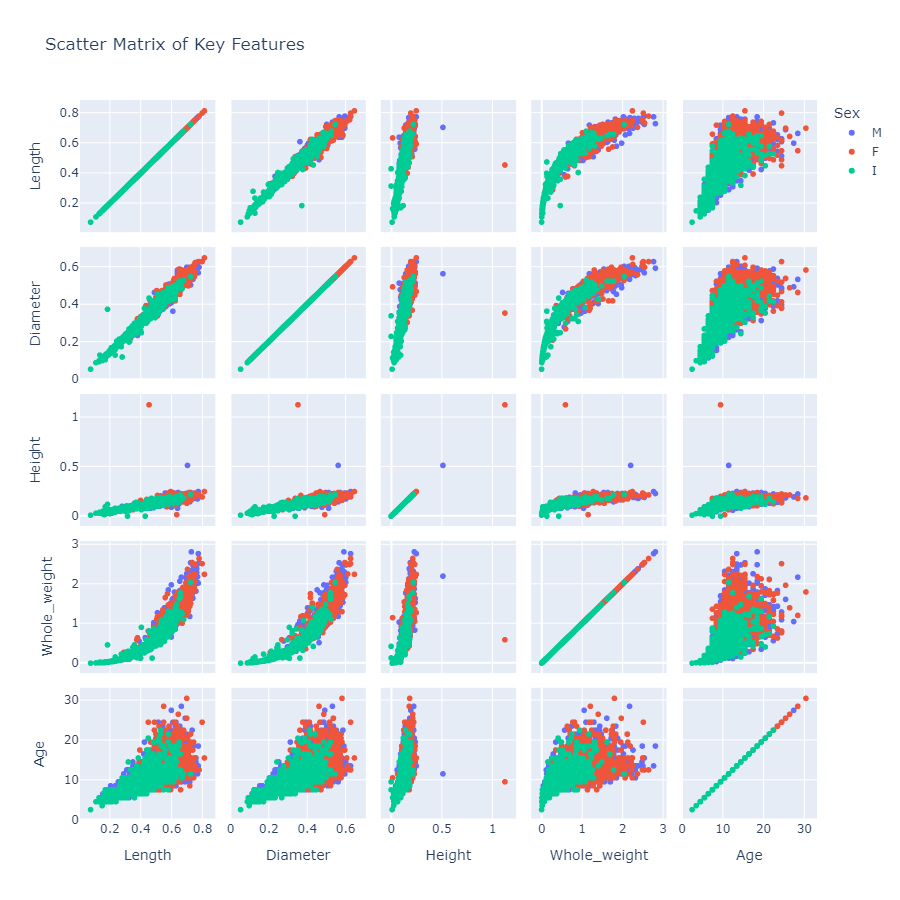

In [356]:
fig = px.scatter_matrix(df,
                        dimensions=['Length', 'Diameter', 'Height', 'Whole_weight', 'Age'],
                        color='Sex',
                        title='Scatter Matrix of Key Features')
fig.update_layout(width=900, height=900)
Image('figures/Scatterplot.png')

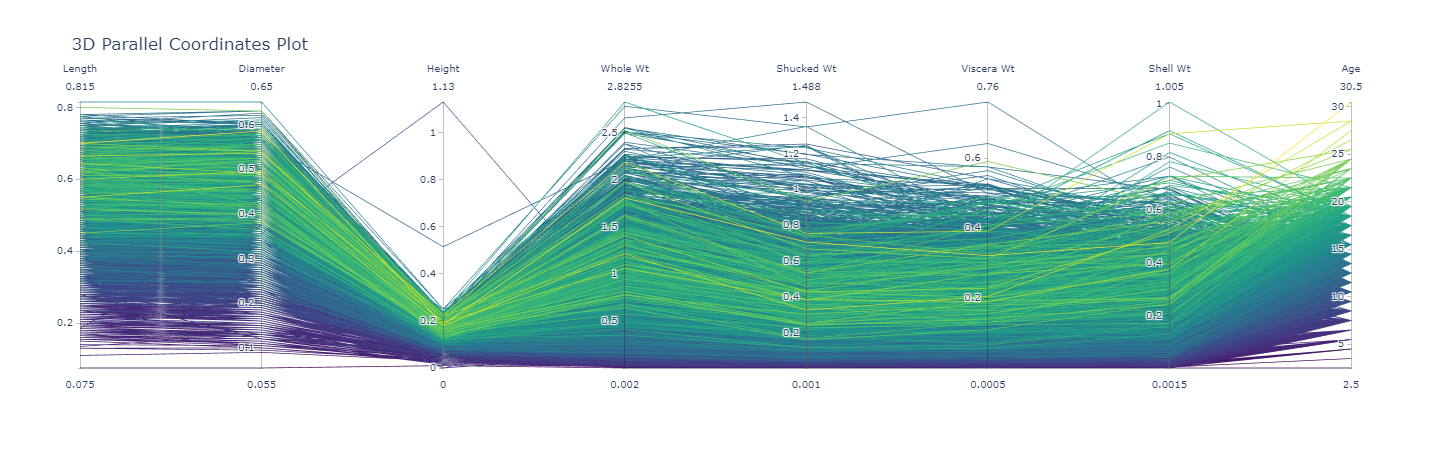

In [357]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line=dict(color=df['Age'], colorscale='Viridis'),
        dimensions=list([
            dict(label='Length', values=df['Length']),
            dict(label='Diameter', values=df['Diameter']),
            dict(label='Height', values=df['Height']),
            dict(label='Whole Wt', values=df['Whole_weight']),
            dict(label='Shucked Wt', values=df['Shucked_weight']),
            dict(label='Viscera Wt', values=df['Viscera_weight']),
            dict(label='Shell Wt', values=df['Shell_weight']),
            dict(label='Age', values=df['Age']),
        ])
    )
)
fig.update_layout(title='3D Parallel Coordinates Plot')
Image('figures/ParallelCoordinates.png')


Parallel Coordinates Plot shows that younger abalones (purple lines) generally exhibit smaller sizes and lower weights. However, between the ages of 10 and 30, the influence of age becomes less pronounced, as shown by the more dispersed and less consistent patterns across the features.

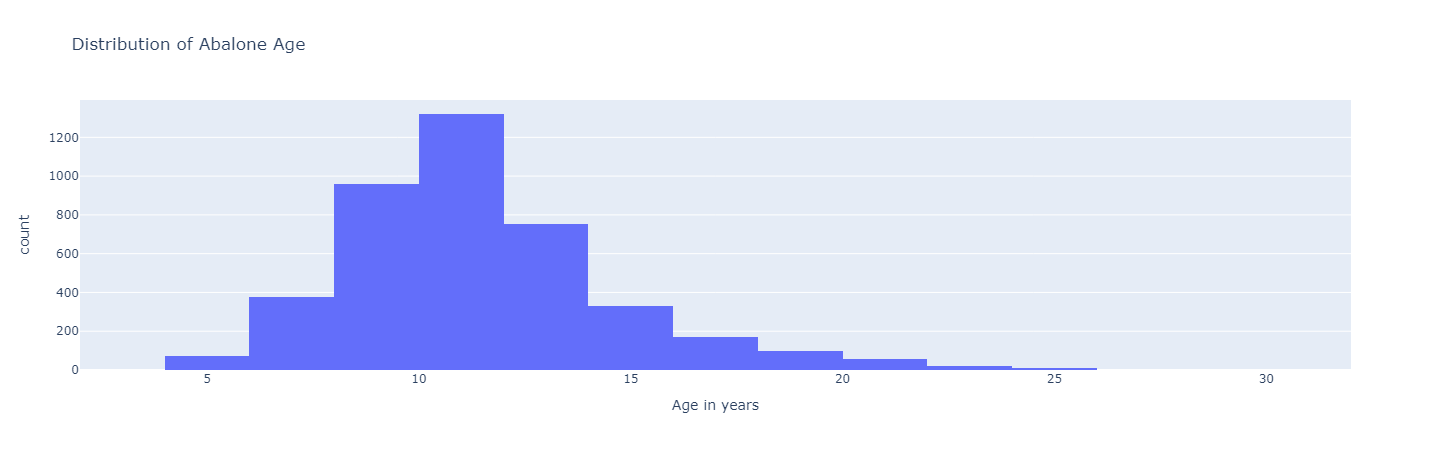

In [358]:
fig = px.histogram(df, x='Age', nbins=20,
                   title='Distribution of Abalone Age',
                   labels={'Age': 'Age in years'})
Image("figures/histogram.png")

Mapping Sex to numbers

In [359]:
df['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [360]:
df['Sex'] = df['Sex'].map({'M':0,'F':1,'I':2})
df['Sex']

0       0
1       0
2       1
3       0
4       2
       ..
4172    1
4173    0
4174    0
4175    1
4176    0
Name: Sex, Length: 4177, dtype: int64

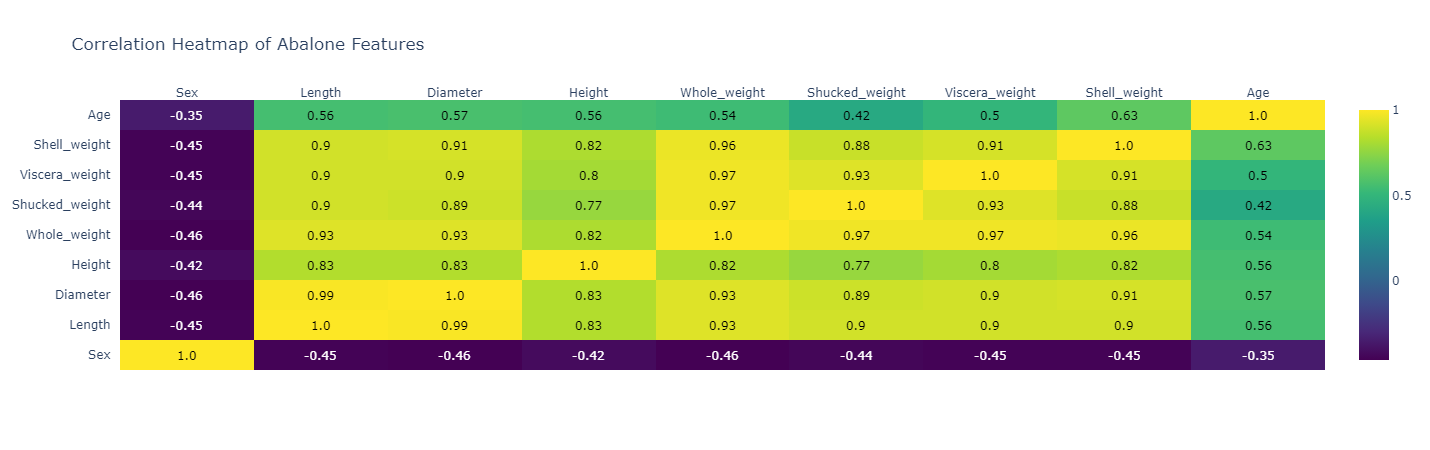

In [361]:
corr = df.corr()
z = np.round(corr.values, 2)

fig = ff.create_annotated_heatmap(
    z=z,
    x=corr.columns.tolist(),
    y=corr.columns.tolist(),
    showscale=True,
    colorscale='Viridis'
)
fig.update_layout(title='Correlation Heatmap of Abalone Features')
Image("figures/heatmap.png")


Decently high correlation between age and each feature.

In [362]:
y = df['Age']
X = df.drop('Age', axis=1)
X

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3341, 8)
X_test shape: (836, 8)
y_train shape: (3341,)
y_test shape: (836,)


First model is going to be a default SGD Regressor.

In [364]:
pipe = make_pipeline(StandardScaler(), SGDRegressor(random_state=62)).fit(X_train, y_train)
mse_scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-mse_scores)
print("Default SGD RMSE (per fold):", rmse_scores)
print("Default SGD Average RMSE:", rmse_scores.mean())

y_pred = pipe.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nDefault SGD Test Set RMSE: {test_rmse}")

Default SGD RMSE (per fold): [2.18933542 2.18816739 2.21346693 2.24047954 2.44097389]
Default SGD Average RMSE: 2.25448463641325

Default SGD Test Set RMSE: 2.242222920326077


Grid Search to see if we can get a better score.

In [365]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'sgdregressor': SGDRegressor(random_state=62)}

In [366]:
params = {
    'sgdregressor__penalty': ['l1','l2','elasticnet'],
    'sgdregressor__alpha': np.linspace(0.005, 0.000001, 20)
}
grid = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=5).fit(X_train, y_train)
print(grid.best_params_)
print("SGD Grid Search RMSE:", -grid.best_score_)

y_pred = grid.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nSGD Grid Search Test Set RMSE: {test_rmse}")

{'sgdregressor__alpha': 0.0010534210526315785, 'sgdregressor__penalty': 'l1'}
SGD Grid Search RMSE: 2.2539988730966973

SGD Grid Search Test Set RMSE: 2.2419622188752237


Tiny improvement in test set. Moving on to XGB Regressor.

In [367]:
xgb = make_pipeline(StandardScaler(), XGBRegressor(random_state=62)).fit(X_train,y_train)
mse_scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-mse_scores)
print("Default XGB RMSE (per fold):", rmse_scores)
print("Default XGB Average RMSE:", rmse_scores.mean())

y_pred = xgb.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nDefault XGB Test Set RMSE: {test_rmse}")

Default XGB RMSE (per fold): [2.25824903 2.30113091 2.38726209 2.38576925 2.34528542]
Default XGB Average RMSE: 2.335539340676566

Default XGB Test Set RMSE: 2.381042571226204


Not a great score. XGB defaults to 100 estimators which may be too complex for this dataset. Hypothesizing that a lower number of estimators improves the score.

In [368]:
xgb.named_steps

{'standardscaler': StandardScaler(),
 'xgbregressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=62, ...)}

In [ ]:
params = {
    'xgbregressor__n_estimators': [50, 100, 200],
    'xgbregressor__max_depth': [3, 4, 5],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(xgb, param_grid=params, scoring='neg_root_mean_squared_error', cv=5).fit(X_train, y_train)
print(grid.best_params_)
print("XGB Grid Search RMSE:", -grid.best_score_)

y_pred = grid.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nXGB Grid Search Test Set RMSE: {test_rmse}")

{'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100, 'xgbregressor__subsample': 0.8}
XGB Grid Search RMSE: 2.128183155222497

XGB Grid Search Test Set RMSE: 2.2004702019987947


Pretty big improvement. Random Forests next.

In [377]:
rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=62)).fit(X_train,y_train)
mse_scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-mse_scores)
print("Default Random Forest RMSE (per fold):", rmse_scores)
print("Default Random Forest Average RMSE:", rmse_scores.mean())

y_pred = rf.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nDefault Random Forest Test Set RMSE: {test_rmse}")

Default Random Forest RMSE (per fold): [2.15976636 2.15243776 2.16838184 2.24947486 2.19257279]
Default Random Forest Average RMSE: 2.184526721633616

Default Random Forest Test Set RMSE: 2.2244569521699935


Random Forest is really slow so I don't want to do a grid search. Best model was the tuned XGB Regressor.

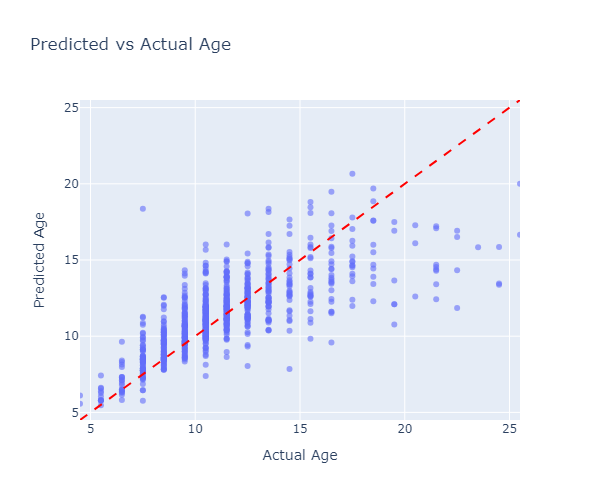

In [385]:
y_pred = grid.predict(X_test)

df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

min_val = min(df_result['Actual'].min(), df_result['Predicted'].min())
max_val = max(df_result['Actual'].max(), df_result['Predicted'].max())

fig = px.scatter(df_result, x='Actual', y='Predicted', opacity=0.6,
                 title='Predicted vs Actual Age')

fig.add_shape(
    type='line',
    x0=min_val, x1=max_val,
    y0=min_val, y1=max_val,
    line=dict(color='red', dash='dash')
)

fig.update_layout(
    xaxis=dict(title='Actual Age', range=[min_val, max_val]),
    yaxis=dict(title='Predicted Age', range=[min_val, max_val]),
    width=600, height=500
)

Image('figures/Predicted.png')
